In [112]:
import cv2
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
%matplotlib widget

# Предварительная обработка

## Загрузка

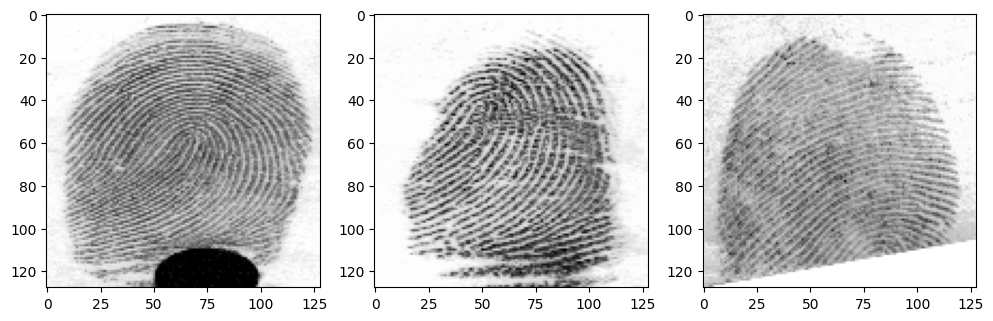

In [81]:
image1 = cv2.imread("./minex_dataset/a010_02.gray.png")
image2 = cv2.imread("./minex_dataset/b010_02.gray.png")
image3 = cv2.imread("./minex_dataset/a004_10.gray.png")


image1_gray = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2_gray = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
image3_gray = cv2.cvtColor(image3, cv2.COLOR_RGB2GRAY)

image1_gray = cv2.resize(image1_gray, (128,128))
image2_gray = cv2.resize(image2_gray, (128,128))
image3_gray = cv2.resize(image3_gray, (128,128))

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(image1_gray, cmap="gray")
plt.subplot(132)
plt.imshow(image2_gray, cmap="gray")
plt.subplot(133)
plt.imshow(image3_gray, cmap="gray")

## Нормализация

[[254 254 254 ... 253 253 252]
 [255 254 254 ... 254 253 253]
 [254 252 253 ... 254 252 253]
 ...
 [250 251 240 ... 254 252 251]
 [249 241 246 ... 247 253 253]
 [246 237 245 ... 247 242 252]]


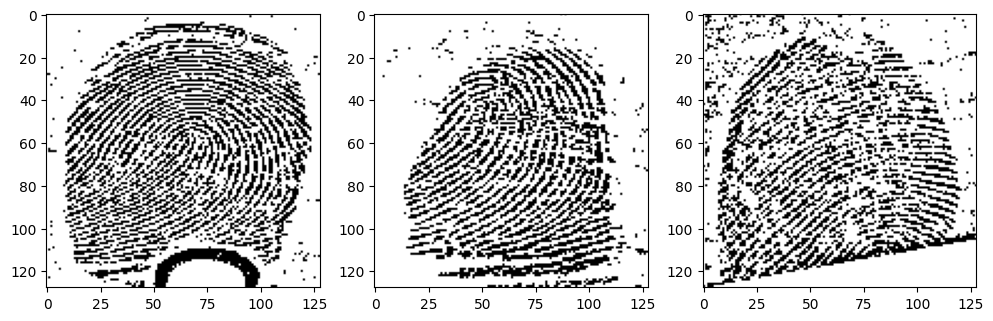

In [82]:
image1_norm = cv2.normalize(image1_gray, image1_gray, 0, 255, norm_type=cv2.NORM_MINMAX)
image2_norm = cv2.normalize(image2_gray, image2_gray, 0, 255, norm_type=cv2.NORM_MINMAX)
image3_norm = cv2.normalize(image3_gray, image3_gray, 0, 255, norm_type=cv2.NORM_MINMAX)
# image1_thresh, thresh1 = cv2.threshold(image1_norm, 100, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
image1_thresh = cv2.adaptiveThreshold(image1_norm,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,21,10)
image2_thresh = cv2.adaptiveThreshold(image2_norm,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,21,10)
image3_thresh = cv2.adaptiveThreshold(image3_norm,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,21,10)
print(image1_gray)
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(image1_thresh, cmap="gray")
plt.subplot(132)
plt.imshow(image2_thresh, cmap="gray")
plt.subplot(133)
plt.imshow(image3_thresh, cmap="gray")

## Фильтр Габора

In [101]:
def create_gaborfilters(num_filters=8):
    """
    Создаёт множество ядер фильтра Габора, по количеству равное num_filters
    """
     
    filters = []
    ksize = 1  # The local area to evaluate
    sigma = 1.0  # Larger Values produce more edges
    lambd = 10.0
    gamma = 0.5
    psi = 0  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

In [102]:
def apply_filter(img, filters):
    """
    Применяет список ядер фильтров к изображению
    """
    newimage = np.zeros_like(img)
     
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
         
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)
    return newimage

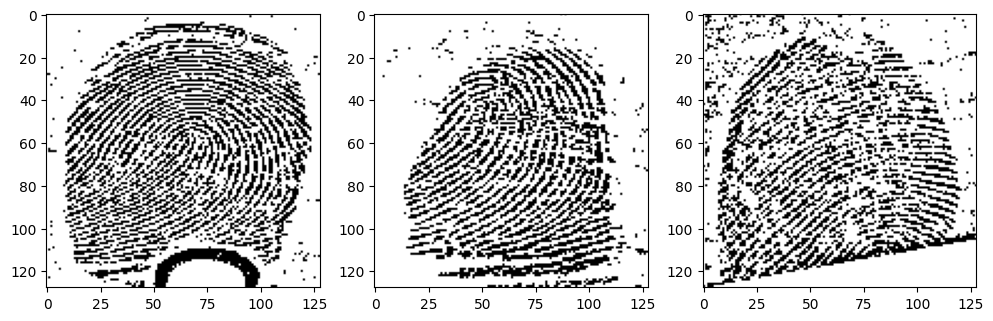

In [110]:
gaborfilters = create_gaborfilters()
image1_filtered = apply_filter(image1_thresh, gaborfilters)
image2_filtered = apply_filter(image2_thresh, gaborfilters)
image3_filtered = apply_filter(image3_thresh, gaborfilters)

# image1_th = cv2.threshold(
ret,image1_th = cv2.threshold(image1_filtered,200,255,cv2.THRESH_BINARY)
ret,image2_th = cv2.threshold(image2_filtered,200,255,cv2.THRESH_BINARY)
ret,image3_th = cv2.threshold(image3_filtered,200,255,cv2.THRESH_BINARY)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(image1_th, cmap="gray")
plt.subplot(132)
plt.imshow(image2_th, cmap="gray")
plt.subplot(133)
plt.imshow(image3_th, cmap="gray")

# Сравнение отпечатков методом ORB/SIFT

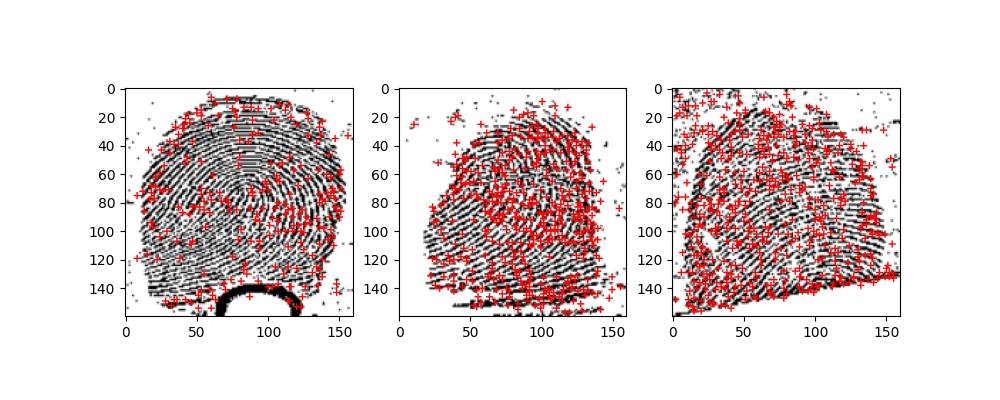

In [115]:
sift = cv2.xfeatures2d.SIFT_create()

image1_th = cv2.resize(src = image1_th,dsize=(160, 160))
image2_th = cv2.resize(src = image2_th,dsize=(160, 160))
image3_th = cv2.resize(src = image3_th,dsize=(160, 160))

keypoints_1, descriptors_1 = sift.detectAndCompute(image1_th, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image2_th, None)
keypoints_3, descriptors_3 = sift.detectAndCompute(image3_th, None)

def draw_cross_keypoints(img, keypoints, color):
    """ Draw keypoints as crosses, and return the new image with the crosses. """
    img_kp = cv2.cvtColor( img.copy(), cv2.COLOR_GRAY2RGB)  # Create a copy of img
    # Iterate over all keypoints and draw a cross on evey point.
    for kp in keypoints:
        x, y = kp.pt  # Each keypoint as an x, y tuple  https://stackoverflow.com/questions/35884409/how-to-extract-x-y-coordinates-from-opencv-cv2-keypoint-object
        x = int(round(x))  # Round an cast to int
        y = int(round(y))
        # Draw a cross with (x, y) center
        cv2.drawMarker(img_kp, (x, y), color, markerType=cv2.MARKER_CROSS, markerSize=5, thickness=1, line_type=cv2.LINE_8)
    return img_kp  # Return the image with the drawn crosses.

image1_draw1 = draw_cross_keypoints(image1_th, keypoints_1, color=(255,0,0))
image2_draw1 = draw_cross_keypoints(image2_th, keypoints_2, color=(255,0,0))
image3_draw1 = draw_cross_keypoints(image3_th, keypoints_3, color=(255,0,0))

plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.imshow(image1_draw1, cmap="gray")
plt.subplot(132)
plt.imshow(image2_draw1, cmap="gray")
plt.subplot(133)
plt.imshow(image3_draw1, cmap="gray")

In [108]:
matcher = cv2.FlannBasedMatcher(
    dict(algorithm=1, trees=20), 
    dict())
matches1 = matcher.knnMatch(descriptors_1, descriptors_2, k=2)
match_points1 = []

for p, q in matches1:
    if p.distance < 0.1*q.distance:
        match_points1.append(p)
        
print("match_points1=", match_points1)

matches2 = matcher.knnMatch(descriptors_1, descriptors_3, k=2)
match_points2 = []

for p, q in matches2:
    if p.distance < 0.1*q.distance:
        match_points2.append(p)
        
print("match_points1=", match_points2)

match_points1= [< cv2.DMatch 000001FFDEBEDB30>, < cv2.DMatch 000001FFDE628F70>, < cv2.DMatch 000001FFDE628790>, < cv2.DMatch 000001FFDFC309B0>, < cv2.DMatch 000001FFDFC30F30>, < cv2.DMatch 000001FFDFC307B0>, < cv2.DMatch 000001FFDFC30DB0>, < cv2.DMatch 000001FFDFC30970>, < cv2.DMatch 000001FFDFC31690>, < cv2.DMatch 000001FFDFC30E70>, < cv2.DMatch 000001FFDFC31070>, < cv2.DMatch 000001FFDFC30A70>, < cv2.DMatch 000001FFDFC315F0>, < cv2.DMatch 000001FFDFC30450>, < cv2.DMatch 000001FFDFC313D0>, < cv2.DMatch 000001FFDFC31550>, < cv2.DMatch 000001FFDFC31650>, < cv2.DMatch 000001FFDFC31210>, < cv2.DMatch 000001FFDFC30EB0>, < cv2.DMatch 000001FFDFC316F0>, < cv2.DMatch 000001FFDFC31730>, < cv2.DMatch 000001FFDFC31770>, < cv2.DMatch 000001FFDFC317B0>, < cv2.DMatch 000001FFDFC317F0>, < cv2.DMatch 000001FFDFC31830>, < cv2.DMatch 000001FFDFC31870>, < cv2.DMatch 000001FFDFC318B0>, < cv2.DMatch 000001FFDFC318F0>, < cv2.DMatch 000001FFDFC31930>, < cv2.DMatch 000001FFDFC31970>, < cv2.DMatch 000001FFDFC

keypoints =  311


TypeError: Image data of dtype object cannot be converted to float

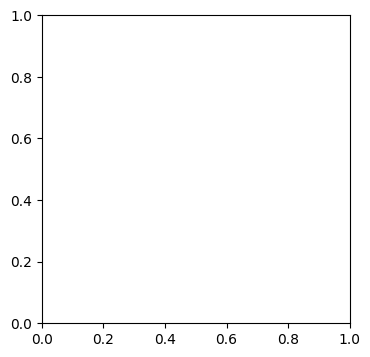

In [106]:
# keypoints = 0
# if len(keypoints_1) <= len(keypoints_2):
#     keypoints = len(keypoints_1)            
# else:
#     keypoints = len(keypoints_2)
keypoints = min(len(keypoints_1), len(keypoints_2))
print("keypoints = ", keypoints)
result = None
if (len(match_points1) / keypoints)>0.05:
    print("% match: ", len(match_points1) / keypoints * 100)
    # print("Figerprint ID: " + str(file)) 
    result = cv2.drawMatches(image1, keypoints_1,
                       image2, match_points1, None) 
    result = cv2.resize(result, None, fx=2.5, fy=2.5)

plt.figure(figsize=(12, 4))
plt.imshow(result)